<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:04:40] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


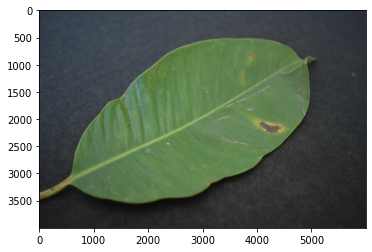

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

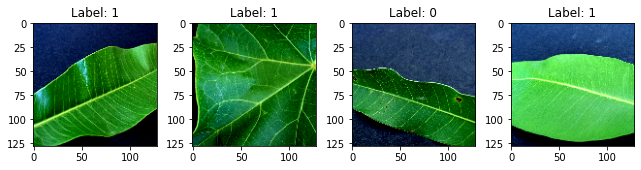

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:04:45] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:04:47] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2393159406834995 samples/sec                   batch loss = 0.6264523863792419 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2537617974424695 samples/sec                   batch loss = 0.8915637731552124 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2496208618526432 samples/sec                   batch loss = 0.5019630789756775 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2517041071361958 samples/sec                   batch loss = 0.5291329026222229 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2550307556000266 samples/sec                   batch loss = 0.189509317278862 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.249246065096818 samples/sec                   batch loss = 0.5244432687759399 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.250773177661033 samples/sec                   batch loss = 0.38486334681510925 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2504385086873688 samples/sec                   batch loss = 0.44513562321662903 | accuracy = 0.6125


Epoch[1] Batch[45] Speed: 1.253659960714627 samples/sec                   batch loss = 0.5088619589805603 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2530968316858748 samples/sec                   batch loss = 0.8113017678260803 | accuracy = 0.58


Epoch[1] Batch[55] Speed: 1.2530795169809246 samples/sec                   batch loss = 0.6872490048408508 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.252255703187348 samples/sec                   batch loss = 0.8917927742004395 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2526004171000416 samples/sec                   batch loss = 0.5750229358673096 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2548787767703589 samples/sec                   batch loss = 0.41811662912368774 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.2515618025003163 samples/sec                   batch loss = 1.2758867740631104 | accuracy = 0.6233333333333333


Epoch[1] Batch[80] Speed: 1.2519674186707377 samples/sec                   batch loss = 0.4456208050251007 | accuracy = 0.621875


Epoch[1] Batch[85] Speed: 1.2523566575070713 samples/sec                   batch loss = 0.38205665349960327 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2480126303768477 samples/sec                   batch loss = 0.47246068716049194 | accuracy = 0.6361111111111111


Epoch[1] Batch[95] Speed: 1.2518570926935377 samples/sec                   batch loss = 0.7159004807472229 | accuracy = 0.6421052631578947


Epoch[1] Batch[100] Speed: 1.2481414076833248 samples/sec                   batch loss = 0.6177970170974731 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.25546690165803 samples/sec                   batch loss = 0.6634734869003296 | accuracy = 0.6547619047619048


Epoch[1] Batch[110] Speed: 1.2563747259929703 samples/sec                   batch loss = 0.5149320363998413 | accuracy = 0.6545454545454545


Epoch[1] Batch[115] Speed: 1.251005127213213 samples/sec                   batch loss = 0.2410484254360199 | accuracy = 0.6543478260869565


Epoch[1] Batch[120] Speed: 1.2452742240090113 samples/sec                   batch loss = 0.37866055965423584 | accuracy = 0.6520833333333333


Epoch[1] Batch[125] Speed: 1.2472526708683307 samples/sec                   batch loss = 0.5265201330184937 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.2472433058829844 samples/sec                   batch loss = 0.6869128942489624 | accuracy = 0.6538461538461539


Epoch[1] Batch[135] Speed: 1.25193565475347 samples/sec                   batch loss = 0.5298030376434326 | accuracy = 0.6574074074074074


Epoch[1] Batch[140] Speed: 1.2553737114944867 samples/sec                   batch loss = 0.5657250881195068 | accuracy = 0.6589285714285714


Epoch[1] Batch[145] Speed: 1.2533899439631266 samples/sec                   batch loss = 0.44972658157348633 | accuracy = 0.6586206896551724


Epoch[1] Batch[150] Speed: 1.2497299561784485 samples/sec                   batch loss = 0.6295479536056519 | accuracy = 0.6583333333333333


Epoch[1] Batch[155] Speed: 1.2509292934685436 samples/sec                   batch loss = 0.46675577759742737 | accuracy = 0.6612903225806451


Epoch[1] Batch[160] Speed: 1.2575058875732106 samples/sec                   batch loss = 0.9294978976249695 | accuracy = 0.6609375


Epoch[1] Batch[165] Speed: 1.256131658452788 samples/sec                   batch loss = 0.3178274929523468 | accuracy = 0.6590909090909091


Epoch[1] Batch[170] Speed: 1.252156634217641 samples/sec                   batch loss = 0.3687743544578552 | accuracy = 0.6602941176470588


Epoch[1] Batch[175] Speed: 1.2526677552299157 samples/sec                   batch loss = 0.41858020424842834 | accuracy = 0.66


Epoch[1] Batch[180] Speed: 1.2543208355432134 samples/sec                   batch loss = 0.3846675455570221 | accuracy = 0.6638888888888889


Epoch[1] Batch[185] Speed: 1.254333401817246 samples/sec                   batch loss = 0.7302970886230469 | accuracy = 0.6635135135135135


Epoch[1] Batch[190] Speed: 1.2563196889201698 samples/sec                   batch loss = 0.42029669880867004 | accuracy = 0.6618421052631579


Epoch[1] Batch[195] Speed: 1.2502452467147671 samples/sec                   batch loss = 0.41428184509277344 | accuracy = 0.6602564102564102


Epoch[1] Batch[200] Speed: 1.256770758736081 samples/sec                   batch loss = 0.819554328918457 | accuracy = 0.66


Epoch[1] Batch[205] Speed: 1.2561294953482178 samples/sec                   batch loss = 0.7417399883270264 | accuracy = 0.6621951219512195


Epoch[1] Batch[210] Speed: 1.2558722330950298 samples/sec                   batch loss = 0.9706912636756897 | accuracy = 0.6619047619047619


Epoch[1] Batch[215] Speed: 1.2544570148569405 samples/sec                   batch loss = 0.9689815044403076 | accuracy = 0.6616279069767442


Epoch[1] Batch[220] Speed: 1.2552133853986678 samples/sec                   batch loss = 0.723422646522522 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.2523254347103983 samples/sec                   batch loss = 0.6705081462860107 | accuracy = 0.6611111111111111


Epoch[1] Batch[230] Speed: 1.2525340213110951 samples/sec                   batch loss = 1.0749762058258057 | accuracy = 0.6619565217391304


Epoch[1] Batch[235] Speed: 1.251560775484734 samples/sec                   batch loss = 0.4774203896522522 | accuracy = 0.6648936170212766


Epoch[1] Batch[240] Speed: 1.2519244443439554 samples/sec                   batch loss = 0.5078867673873901 | accuracy = 0.6677083333333333


Epoch[1] Batch[245] Speed: 1.2453521468631106 samples/sec                   batch loss = 0.3269078731536865 | accuracy = 0.6673469387755102


Epoch[1] Batch[250] Speed: 1.2523509550238094 samples/sec                   batch loss = 0.5670447945594788 | accuracy = 0.667


Epoch[1] Batch[255] Speed: 1.2512799966408221 samples/sec                   batch loss = 0.40642985701560974 | accuracy = 0.6656862745098039


Epoch[1] Batch[260] Speed: 1.253264200633235 samples/sec                   batch loss = 0.5051784515380859 | accuracy = 0.6653846153846154


Epoch[1] Batch[265] Speed: 1.2580518556344655 samples/sec                   batch loss = 0.8573545217514038 | accuracy = 0.6632075471698113


Epoch[1] Batch[270] Speed: 1.25546690165803 samples/sec                   batch loss = 0.9692580699920654 | accuracy = 0.662962962962963


Epoch[1] Batch[275] Speed: 1.2478210455619512 samples/sec                   batch loss = 0.26495206356048584 | accuracy = 0.6627272727272727


Epoch[1] Batch[280] Speed: 1.2528545629097096 samples/sec                   batch loss = 0.2159828096628189 | accuracy = 0.6625


Epoch[1] Batch[285] Speed: 1.2495552468802484 samples/sec                   batch loss = 0.7050819993019104 | accuracy = 0.6640350877192982


Epoch[1] Batch[290] Speed: 1.2522161671811334 samples/sec                   batch loss = 0.28057536482810974 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.2539953255136218 samples/sec                   batch loss = 0.7732052803039551 | accuracy = 0.6610169491525424


Epoch[1] Batch[300] Speed: 1.2546680949422353 samples/sec                   batch loss = 0.33751994371414185 | accuracy = 0.6633333333333333


Epoch[1] Batch[305] Speed: 1.2563989061974035 samples/sec                   batch loss = 0.31695887446403503 | accuracy = 0.6639344262295082


Epoch[1] Batch[310] Speed: 1.2542536008770766 samples/sec                   batch loss = 0.6921237707138062 | accuracy = 0.6645161290322581


Epoch[1] Batch[315] Speed: 1.2541600282210406 samples/sec                   batch loss = 0.4624507427215576 | accuracy = 0.6626984126984127


Epoch[1] Batch[320] Speed: 1.244910066293186 samples/sec                   batch loss = 0.4162973463535309 | accuracy = 0.6640625


Epoch[1] Batch[325] Speed: 1.2525536587691177 samples/sec                   batch loss = 0.4639185965061188 | accuracy = 0.6646153846153846


Epoch[1] Batch[330] Speed: 1.2534390122397188 samples/sec                   batch loss = 0.41572731733322144 | accuracy = 0.6674242424242425


Epoch[1] Batch[335] Speed: 1.25301278964765 samples/sec                   batch loss = 0.9868570566177368 | accuracy = 0.6701492537313433


Epoch[1] Batch[340] Speed: 1.2481879300285732 samples/sec                   batch loss = 0.3014814555644989 | accuracy = 0.6705882352941176


Epoch[1] Batch[345] Speed: 1.2505113934678187 samples/sec                   batch loss = 0.4204530119895935 | accuracy = 0.6717391304347826


Epoch[1] Batch[350] Speed: 1.2590512892633283 samples/sec                   batch loss = 0.4940643310546875 | accuracy = 0.67


Epoch[1] Batch[355] Speed: 1.250937594623446 samples/sec                   batch loss = 0.4395589828491211 | accuracy = 0.6697183098591549


Epoch[1] Batch[360] Speed: 1.2512031964522579 samples/sec                   batch loss = 0.43660807609558105 | accuracy = 0.6694444444444444


Epoch[1] Batch[365] Speed: 1.2573885521930943 samples/sec                   batch loss = 0.684169352054596 | accuracy = 0.6691780821917809


Epoch[1] Batch[370] Speed: 1.2572268631683132 samples/sec                   batch loss = 0.37294626235961914 | accuracy = 0.6709459459459459


Epoch[1] Batch[375] Speed: 1.2555382127493597 samples/sec                   batch loss = 0.44485536217689514 | accuracy = 0.6713333333333333


Epoch[1] Batch[380] Speed: 1.2500460835398834 samples/sec                   batch loss = 0.7046210765838623 | accuracy = 0.6717105263157894


Epoch[1] Batch[385] Speed: 1.2500829677214955 samples/sec                   batch loss = 0.48474857211112976 | accuracy = 0.6707792207792208


Epoch[1] Batch[390] Speed: 1.2490554033104568 samples/sec                   batch loss = 0.4494595527648926 | accuracy = 0.6711538461538461


Epoch[1] Batch[395] Speed: 1.2551741319400933 samples/sec                   batch loss = 0.19803814589977264 | accuracy = 0.6715189873417722


Epoch[1] Batch[400] Speed: 1.2578600998972627 samples/sec                   batch loss = 1.8083240985870361 | accuracy = 0.670625


Epoch[1] Batch[405] Speed: 1.251899595318611 samples/sec                   batch loss = 0.6019478440284729 | accuracy = 0.6703703703703704


Epoch[1] Batch[410] Speed: 1.2605663015752406 samples/sec                   batch loss = 0.7605191469192505 | accuracy = 0.6701219512195122


Epoch[1] Batch[415] Speed: 1.254015664940776 samples/sec                   batch loss = 0.5298157334327698 | accuracy = 0.6704819277108434


Epoch[1] Batch[420] Speed: 1.252773079099165 samples/sec                   batch loss = 0.40854358673095703 | accuracy = 0.6702380952380952


Epoch[1] Batch[425] Speed: 1.2517560321075727 samples/sec                   batch loss = 0.7369213104248047 | accuracy = 0.6694117647058824


Epoch[1] Batch[430] Speed: 1.256932424625669 samples/sec                   batch loss = 0.40488266944885254 | accuracy = 0.6686046511627907


Epoch[1] Batch[435] Speed: 1.2565345019395633 samples/sec                   batch loss = 0.5058527588844299 | accuracy = 0.6689655172413793


Epoch[1] Batch[440] Speed: 1.2527747629282906 samples/sec                   batch loss = 0.4709680378437042 | accuracy = 0.6698863636363637


Epoch[1] Batch[445] Speed: 1.2509999034378008 samples/sec                   batch loss = 0.38223111629486084 | accuracy = 0.6691011235955057


Epoch[1] Batch[450] Speed: 1.2542023123314525 samples/sec                   batch loss = 0.3400421142578125 | accuracy = 0.67


Epoch[1] Batch[455] Speed: 1.2564295797024942 samples/sec                   batch loss = 0.5587729215621948 | accuracy = 0.6708791208791208


Epoch[1] Batch[460] Speed: 1.2528712164739728 samples/sec                   batch loss = 0.2883957028388977 | accuracy = 0.6706521739130434


Epoch[1] Batch[465] Speed: 1.2535509285026405 samples/sec                   batch loss = 0.9599522352218628 | accuracy = 0.6698924731182796


Epoch[1] Batch[470] Speed: 1.2516761852367377 samples/sec                   batch loss = 0.6974796652793884 | accuracy = 0.6702127659574468


Epoch[1] Batch[475] Speed: 1.253334419039501 samples/sec                   batch loss = 1.1054408550262451 | accuracy = 0.67


Epoch[1] Batch[480] Speed: 1.2597559812672185 samples/sec                   batch loss = 0.3821526765823364 | accuracy = 0.6723958333333333


Epoch[1] Batch[485] Speed: 1.25707764866492 samples/sec                   batch loss = 0.6612772941589355 | accuracy = 0.6721649484536083


Epoch[1] Batch[490] Speed: 1.252248506139835 samples/sec                   batch loss = 0.3065624237060547 | accuracy = 0.673469387755102


Epoch[1] Batch[495] Speed: 1.252538135775118 samples/sec                   batch loss = 0.4218178987503052 | accuracy = 0.6732323232323232


Epoch[1] Batch[500] Speed: 1.2501477997398844 samples/sec                   batch loss = 0.3398321568965912 | accuracy = 0.675


Epoch[1] Batch[505] Speed: 1.2541122159213016 samples/sec                   batch loss = 0.6409464478492737 | accuracy = 0.6742574257425743


Epoch[1] Batch[510] Speed: 1.2543545024705838 samples/sec                   batch loss = 0.48848098516464233 | accuracy = 0.6745098039215687


Epoch[1] Batch[515] Speed: 1.255056480180806 samples/sec                   batch loss = 0.27374035120010376 | accuracy = 0.6742718446601942


Epoch[1] Batch[520] Speed: 1.2474084655095665 samples/sec                   batch loss = 0.6721131205558777 | accuracy = 0.675


Epoch[1] Batch[525] Speed: 1.259604085338148 samples/sec                   batch loss = 0.22085875272750854 | accuracy = 0.6761904761904762


Epoch[1] Batch[530] Speed: 1.2613831654843937 samples/sec                   batch loss = 1.6845380067825317 | accuracy = 0.6764150943396227


Epoch[1] Batch[535] Speed: 1.2582681107801672 samples/sec                   batch loss = 0.3412014842033386 | accuracy = 0.6780373831775701


Epoch[1] Batch[540] Speed: 1.2602791012403414 samples/sec                   batch loss = 0.5475003719329834 | accuracy = 0.6777777777777778


Epoch[1] Batch[545] Speed: 1.2577680628184722 samples/sec                   batch loss = 0.2984028458595276 | accuracy = 0.6779816513761467


Epoch[1] Batch[550] Speed: 1.2545985713897927 samples/sec                   batch loss = 0.7661955952644348 | accuracy = 0.6768181818181818


Epoch[1] Batch[555] Speed: 1.2597172944561215 samples/sec                   batch loss = 0.5189355611801147 | accuracy = 0.6774774774774774


Epoch[1] Batch[560] Speed: 1.255860764059834 samples/sec                   batch loss = 0.5477254390716553 | accuracy = 0.6772321428571428


Epoch[1] Batch[565] Speed: 1.2551974207772039 samples/sec                   batch loss = 0.49221551418304443 | accuracy = 0.6783185840707965


Epoch[1] Batch[570] Speed: 1.2589679582259443 samples/sec                   batch loss = 0.6014746427536011 | accuracy = 0.6771929824561403


Epoch[1] Batch[575] Speed: 1.2565220797378331 samples/sec                   batch loss = 0.5109297633171082 | accuracy = 0.6773913043478261


Epoch[1] Batch[580] Speed: 1.2554818396744065 samples/sec                   batch loss = 0.4781433939933777 | accuracy = 0.6775862068965517


Epoch[1] Batch[585] Speed: 1.218716961878048 samples/sec                   batch loss = 0.4529239237308502 | accuracy = 0.6786324786324787


Epoch[1] Batch[590] Speed: 1.2572474017758606 samples/sec                   batch loss = 0.6373823881149292 | accuracy = 0.6771186440677966


Epoch[1] Batch[595] Speed: 1.2571975638392163 samples/sec                   batch loss = 0.3875184655189514 | accuracy = 0.6785714285714286


Epoch[1] Batch[600] Speed: 1.257371495619529 samples/sec                   batch loss = 0.29065021872520447 | accuracy = 0.6804166666666667


Epoch[1] Batch[605] Speed: 1.260197406101404 samples/sec                   batch loss = 0.2994716465473175 | accuracy = 0.6818181818181818


Epoch[1] Batch[610] Speed: 1.2567718884640358 samples/sec                   batch loss = 0.5893949866294861 | accuracy = 0.6815573770491803


Epoch[1] Batch[615] Speed: 1.2610662077167358 samples/sec                   batch loss = 0.41314828395843506 | accuracy = 0.6817073170731708


Epoch[1] Batch[620] Speed: 1.2598531344197252 samples/sec                   batch loss = 0.6594438552856445 | accuracy = 0.6818548387096774


Epoch[1] Batch[625] Speed: 1.2598251315845892 samples/sec                   batch loss = 1.120520830154419 | accuracy = 0.682


Epoch[1] Batch[630] Speed: 1.2607173875765216 samples/sec                   batch loss = 0.1899842470884323 | accuracy = 0.6833333333333333


Epoch[1] Batch[635] Speed: 1.254496035867492 samples/sec                   batch loss = 0.297314316034317 | accuracy = 0.684251968503937


Epoch[1] Batch[640] Speed: 1.2475888835215982 samples/sec                   batch loss = 0.34467026591300964 | accuracy = 0.685546875


Epoch[1] Batch[645] Speed: 1.2524284571492388 samples/sec                   batch loss = 0.8929399847984314 | accuracy = 0.6856589147286821


Epoch[1] Batch[650] Speed: 1.2481318436389244 samples/sec                   batch loss = 0.3166506290435791 | accuracy = 0.6876923076923077


Epoch[1] Batch[655] Speed: 1.252143550808595 samples/sec                   batch loss = 0.41672152280807495 | accuracy = 0.6881679389312977


Epoch[1] Batch[660] Speed: 1.2498376729315925 samples/sec                   batch loss = 0.6615200042724609 | accuracy = 0.6890151515151515


Epoch[1] Batch[665] Speed: 1.2461924471622914 samples/sec                   batch loss = 0.279282808303833 | accuracy = 0.6890977443609022


Epoch[1] Batch[670] Speed: 1.2491238488452285 samples/sec                   batch loss = 0.45601218938827515 | accuracy = 0.6906716417910448


Epoch[1] Batch[675] Speed: 1.2517434240296577 samples/sec                   batch loss = 0.782963752746582 | accuracy = 0.6911111111111111


Epoch[1] Batch[680] Speed: 1.2528254670144194 samples/sec                   batch loss = 0.4916627109050751 | accuracy = 0.6915441176470588


Epoch[1] Batch[685] Speed: 1.2557522886290426 samples/sec                   batch loss = 0.4279381334781647 | accuracy = 0.6908759124087591


Epoch[1] Batch[690] Speed: 1.257418143147759 samples/sec                   batch loss = 0.3537384867668152 | accuracy = 0.6898550724637681


Epoch[1] Batch[695] Speed: 1.2564905547981826 samples/sec                   batch loss = 0.46218815445899963 | accuracy = 0.6906474820143885


Epoch[1] Batch[700] Speed: 1.2531336153227355 samples/sec                   batch loss = 0.5258814692497253 | accuracy = 0.6889285714285714


Epoch[1] Batch[705] Speed: 1.2557258776046414 samples/sec                   batch loss = 0.4570735692977905 | accuracy = 0.6893617021276596


Epoch[1] Batch[710] Speed: 1.2572282763537568 samples/sec                   batch loss = 0.48241740465164185 | accuracy = 0.6897887323943662


Epoch[1] Batch[715] Speed: 1.2575189890268132 samples/sec                   batch loss = 0.4668942391872406 | accuracy = 0.6898601398601398


Epoch[1] Batch[720] Speed: 1.2524163964778119 samples/sec                   batch loss = 0.19809792935848236 | accuracy = 0.690625


Epoch[1] Batch[725] Speed: 1.2522835574755447 samples/sec                   batch loss = 0.614648163318634 | accuracy = 0.6913793103448276


Epoch[1] Batch[730] Speed: 1.2446415890849818 samples/sec                   batch loss = 0.3119913637638092 | accuracy = 0.6921232876712329


Epoch[1] Batch[735] Speed: 1.2535157125278753 samples/sec                   batch loss = 0.5185818672180176 | accuracy = 0.6921768707482994


Epoch[1] Batch[740] Speed: 1.2459250820790944 samples/sec                   batch loss = 0.2629697620868683 | accuracy = 0.6932432432432433


Epoch[1] Batch[745] Speed: 1.2494871262851261 samples/sec                   batch loss = 0.5120980143547058 | accuracy = 0.6932885906040268


Epoch[1] Batch[750] Speed: 1.250708374002389 samples/sec                   batch loss = 0.28109991550445557 | accuracy = 0.6936666666666667


Epoch[1] Batch[755] Speed: 1.2472622214437723 samples/sec                   batch loss = 0.4228513240814209 | accuracy = 0.6933774834437086


Epoch[1] Batch[760] Speed: 1.2509791953288232 samples/sec                   batch loss = 0.5806311368942261 | accuracy = 0.6934210526315789


Epoch[1] Batch[765] Speed: 1.2529064898107536 samples/sec                   batch loss = 0.3269939422607422 | accuracy = 0.6947712418300653


Epoch[1] Batch[770] Speed: 1.2533494936165686 samples/sec                   batch loss = 0.34832656383514404 | accuracy = 0.6961038961038961


Epoch[1] Batch[775] Speed: 1.256369645445773 samples/sec                   batch loss = 0.25754106044769287 | accuracy = 0.6970967741935484


Epoch[1] Batch[780] Speed: 1.2600860981403437 samples/sec                   batch loss = 0.6627292037010193 | accuracy = 0.6974358974358974


Epoch[1] Batch[785] Speed: 1.258618220479136 samples/sec                   batch loss = 0.7107080221176147 | accuracy = 0.697452229299363


[Epoch 1] training: accuracy=0.6973350253807107
[Epoch 1] time cost: 655.4635252952576
[Epoch 1] validation: validation accuracy=0.7222222222222222


Epoch[2] Batch[5] Speed: 1.253218048019811 samples/sec                   batch loss = 0.4583243131637573 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2546362876644974 samples/sec                   batch loss = 0.5749433636665344 | accuracy = 0.875


Epoch[2] Batch[15] Speed: 1.2504811946506897 samples/sec                   batch loss = 0.24700212478637695 | accuracy = 0.9


Epoch[2] Batch[20] Speed: 1.2451985289375231 samples/sec                   batch loss = 0.7447647452354431 | accuracy = 0.8375


Epoch[2] Batch[25] Speed: 1.2476908497329402 samples/sec                   batch loss = 0.2447110116481781 | accuracy = 0.85


Epoch[2] Batch[30] Speed: 1.242839964987285 samples/sec                   batch loss = 1.1212573051452637 | accuracy = 0.8166666666666667


Epoch[2] Batch[35] Speed: 1.2473132221379968 samples/sec                   batch loss = 0.38635554909706116 | accuracy = 0.8142857142857143


Epoch[2] Batch[40] Speed: 1.2475559498625342 samples/sec                   batch loss = 0.4853501617908478 | accuracy = 0.80625


Epoch[2] Batch[45] Speed: 1.250341683866686 samples/sec                   batch loss = 0.1736551970243454 | accuracy = 0.7944444444444444


Epoch[2] Batch[50] Speed: 1.2558520214114137 samples/sec                   batch loss = 0.2976156771183014 | accuracy = 0.805


Epoch[2] Batch[55] Speed: 1.255637535632195 samples/sec                   batch loss = 0.8595698475837708 | accuracy = 0.7863636363636364


Epoch[2] Batch[60] Speed: 1.2595688121353692 samples/sec                   batch loss = 0.6201124787330627 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.2543014239580674 samples/sec                   batch loss = 0.85016930103302 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2514427732814255 samples/sec                   batch loss = 0.23314888775348663 | accuracy = 0.7678571428571429


Epoch[2] Batch[75] Speed: 1.2544685520664294 samples/sec                   batch loss = 0.19949360191822052 | accuracy = 0.77


Epoch[2] Batch[80] Speed: 1.2566502660825494 samples/sec                   batch loss = 0.3963204026222229 | accuracy = 0.76875


Epoch[2] Batch[85] Speed: 1.253006426121707 samples/sec                   batch loss = 0.24283240735530853 | accuracy = 0.7735294117647059


Epoch[2] Batch[90] Speed: 1.2539663640578418 samples/sec                   batch loss = 0.7673895955085754 | accuracy = 0.7805555555555556


Epoch[2] Batch[95] Speed: 1.250871188468901 samples/sec                   batch loss = 0.9424015879631042 | accuracy = 0.7763157894736842


Epoch[2] Batch[100] Speed: 1.2547978740884844 samples/sec                   batch loss = 0.6513655185699463 | accuracy = 0.7625


Epoch[2] Batch[105] Speed: 1.259737725336561 samples/sec                   batch loss = 0.3799716532230377 | accuracy = 0.7642857142857142


Epoch[2] Batch[110] Speed: 1.2534113874510908 samples/sec                   batch loss = 0.5106827020645142 | accuracy = 0.7613636363636364


Epoch[2] Batch[115] Speed: 1.2515314595688631 samples/sec                   batch loss = 0.24403581023216248 | accuracy = 0.7630434782608696


Epoch[2] Batch[120] Speed: 1.2624144032427913 samples/sec                   batch loss = 0.42322346568107605 | accuracy = 0.76875


Epoch[2] Batch[125] Speed: 1.2574081536888682 samples/sec                   batch loss = 0.3707968294620514 | accuracy = 0.768


Epoch[2] Batch[130] Speed: 1.259996573862809 samples/sec                   batch loss = 0.8595458269119263 | accuracy = 0.7576923076923077


Epoch[2] Batch[135] Speed: 1.2635332519908657 samples/sec                   batch loss = 0.166793555021286 | accuracy = 0.7611111111111111


Epoch[2] Batch[140] Speed: 1.2539547423610984 samples/sec                   batch loss = 1.3416998386383057 | accuracy = 0.7607142857142857


Epoch[2] Batch[145] Speed: 1.2501215307841724 samples/sec                   batch loss = 0.17091676592826843 | accuracy = 0.7586206896551724


Epoch[2] Batch[150] Speed: 1.2574053265123388 samples/sec                   batch loss = 0.7626379132270813 | accuracy = 0.7616666666666667


Epoch[2] Batch[155] Speed: 1.258441394980491 samples/sec                   batch loss = 0.5319463014602661 | accuracy = 0.7645161290322581


Epoch[2] Batch[160] Speed: 1.2512607723797493 samples/sec                   batch loss = 0.29487815499305725 | accuracy = 0.7640625


Epoch[2] Batch[165] Speed: 1.2547699078383854 samples/sec                   batch loss = 0.6151657104492188 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.253899823386033 samples/sec                   batch loss = 0.2953067719936371 | accuracy = 0.7588235294117647


Epoch[2] Batch[175] Speed: 1.2524132177348746 samples/sec                   batch loss = 0.4422805607318878 | accuracy = 0.7571428571428571


Epoch[2] Batch[180] Speed: 1.25607137645817 samples/sec                   batch loss = 0.43801409006118774 | accuracy = 0.7513888888888889


Epoch[2] Batch[185] Speed: 1.2616960128603047 samples/sec                   batch loss = 0.39137107133865356 | accuracy = 0.7513513513513513


Epoch[2] Batch[190] Speed: 1.2573556645178154 samples/sec                   batch loss = 0.2612433433532715 | accuracy = 0.7513157894736842


Epoch[2] Batch[195] Speed: 1.2581316689043829 samples/sec                   batch loss = 0.5100509524345398 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2572527720729063 samples/sec                   batch loss = 0.6872069835662842 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2562496059528856 samples/sec                   batch loss = 0.1657918095588684 | accuracy = 0.7524390243902439


Epoch[2] Batch[210] Speed: 1.2618092187375316 samples/sec                   batch loss = 2.227102756500244 | accuracy = 0.7464285714285714


Epoch[2] Batch[215] Speed: 1.2568854364835649 samples/sec                   batch loss = 0.3964984714984894 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2599659151953297 samples/sec                   batch loss = 0.7197696566581726 | accuracy = 0.7488636363636364


Epoch[2] Batch[225] Speed: 1.25527001612519 samples/sec                   batch loss = 0.32989469170570374 | accuracy = 0.7522222222222222


Epoch[2] Batch[230] Speed: 1.2530366534456086 samples/sec                   batch loss = 0.3711942732334137 | accuracy = 0.7543478260869565


Epoch[2] Batch[235] Speed: 1.2572196088663827 samples/sec                   batch loss = 0.5877725481987 | accuracy = 0.7531914893617021


Epoch[2] Batch[240] Speed: 1.261447183171397 samples/sec                   batch loss = 0.18745163083076477 | accuracy = 0.753125


Epoch[2] Batch[245] Speed: 1.2595343919331978 samples/sec                   batch loss = 0.236444890499115 | accuracy = 0.7540816326530613


Epoch[2] Batch[250] Speed: 1.2583615424102208 samples/sec                   batch loss = 0.5448667407035828 | accuracy = 0.754


Epoch[2] Batch[255] Speed: 1.2576782076415955 samples/sec                   batch loss = 0.6083701252937317 | accuracy = 0.7509803921568627


Epoch[2] Batch[260] Speed: 1.2544075854755574 samples/sec                   batch loss = 0.5592183470726013 | accuracy = 0.75


Epoch[2] Batch[265] Speed: 1.261362965696286 samples/sec                   batch loss = 0.6307846307754517 | accuracy = 0.7518867924528302


Epoch[2] Batch[270] Speed: 1.2553721146062091 samples/sec                   batch loss = 0.30105483531951904 | accuracy = 0.7537037037037037


Epoch[2] Batch[275] Speed: 1.2608752377121673 samples/sec                   batch loss = 0.5043947696685791 | accuracy = 0.7527272727272727


Epoch[2] Batch[280] Speed: 1.2561749221087235 samples/sec                   batch loss = 0.7346089482307434 | accuracy = 0.7544642857142857


Epoch[2] Batch[285] Speed: 1.260130770401902 samples/sec                   batch loss = 0.6575018763542175 | accuracy = 0.7535087719298246


Epoch[2] Batch[290] Speed: 1.258812946495999 samples/sec                   batch loss = 0.22049014270305634 | accuracy = 0.7551724137931034


Epoch[2] Batch[295] Speed: 1.2604441331126663 samples/sec                   batch loss = 0.3322272300720215 | accuracy = 0.7550847457627119


Epoch[2] Batch[300] Speed: 1.2577355324417672 samples/sec                   batch loss = 1.004148244857788 | accuracy = 0.7516666666666667


Epoch[2] Batch[305] Speed: 1.2566919652223572 samples/sec                   batch loss = 0.47273412346839905 | accuracy = 0.7540983606557377


Epoch[2] Batch[310] Speed: 1.2530203698143758 samples/sec                   batch loss = 0.6836550235748291 | accuracy = 0.7556451612903226


Epoch[2] Batch[315] Speed: 1.257934135395668 samples/sec                   batch loss = 0.6540382504463196 | accuracy = 0.753968253968254


Epoch[2] Batch[320] Speed: 1.2580300644093803 samples/sec                   batch loss = 0.24832139909267426 | accuracy = 0.75625


Epoch[2] Batch[325] Speed: 1.2580209142065828 samples/sec                   batch loss = 0.4293316900730133 | accuracy = 0.7553846153846154


Epoch[2] Batch[330] Speed: 1.2562551558625148 samples/sec                   batch loss = 0.19843600690364838 | accuracy = 0.7568181818181818


Epoch[2] Batch[335] Speed: 1.255173286796932 samples/sec                   batch loss = 0.3586622476577759 | accuracy = 0.7597014925373134


Epoch[2] Batch[340] Speed: 1.2572116009679588 samples/sec                   batch loss = 0.8117149472236633 | accuracy = 0.7602941176470588


Epoch[2] Batch[345] Speed: 1.2556340585960506 samples/sec                   batch loss = 0.13555070757865906 | accuracy = 0.7601449275362319


Epoch[2] Batch[350] Speed: 1.254706566076049 samples/sec                   batch loss = 0.6126314997673035 | accuracy = 0.7585714285714286


Epoch[2] Batch[355] Speed: 1.2567117332758255 samples/sec                   batch loss = 0.6061212420463562 | accuracy = 0.7570422535211268


Epoch[2] Batch[360] Speed: 1.2544348790166708 samples/sec                   batch loss = 0.6384512186050415 | accuracy = 0.7555555555555555


Epoch[2] Batch[365] Speed: 1.2590096223657625 samples/sec                   batch loss = 0.44797229766845703 | accuracy = 0.7527397260273972


Epoch[2] Batch[370] Speed: 1.265029410782267 samples/sec                   batch loss = 0.2682185471057892 | accuracy = 0.754054054054054


Epoch[2] Batch[375] Speed: 1.2582283829479812 samples/sec                   batch loss = 0.4554038345813751 | accuracy = 0.7553333333333333


Epoch[2] Batch[380] Speed: 1.2566724801782823 samples/sec                   batch loss = 0.3524567782878876 | accuracy = 0.7559210526315789


Epoch[2] Batch[385] Speed: 1.2567122039513454 samples/sec                   batch loss = 1.430471658706665 | accuracy = 0.7551948051948052


Epoch[2] Batch[390] Speed: 1.251932011348356 samples/sec                   batch loss = 0.8444961309432983 | accuracy = 0.7532051282051282


Epoch[2] Batch[395] Speed: 1.2520742133049663 samples/sec                   batch loss = 0.9924209713935852 | accuracy = 0.7544303797468355


Epoch[2] Batch[400] Speed: 1.2489819443026886 samples/sec                   batch loss = 0.34621506929397583 | accuracy = 0.754375


Epoch[2] Batch[405] Speed: 1.2477299149082506 samples/sec                   batch loss = 0.2904323637485504 | accuracy = 0.7537037037037037


Epoch[2] Batch[410] Speed: 1.2497513677103773 samples/sec                   batch loss = 0.2404153198003769 | accuracy = 0.7542682926829268


Epoch[2] Batch[415] Speed: 1.246489005821728 samples/sec                   batch loss = 0.12546595931053162 | accuracy = 0.7548192771084338


Epoch[2] Batch[420] Speed: 1.2442250184273012 samples/sec                   batch loss = 0.5844107866287231 | accuracy = 0.7547619047619047


Epoch[2] Batch[425] Speed: 1.2482956597489097 samples/sec                   batch loss = 0.5364678502082825 | accuracy = 0.7547058823529412


Epoch[2] Batch[430] Speed: 1.257045907471763 samples/sec                   batch loss = 0.40721389651298523 | accuracy = 0.7540697674418605


Epoch[2] Batch[435] Speed: 1.255811881996671 samples/sec                   batch loss = 0.36147868633270264 | accuracy = 0.7551724137931034


Epoch[2] Batch[440] Speed: 1.2507943452030152 samples/sec                   batch loss = 0.3768090605735779 | accuracy = 0.7539772727272728


Epoch[2] Batch[445] Speed: 1.2555130321502836 samples/sec                   batch loss = 0.8903928399085999 | accuracy = 0.7522471910112359


Epoch[2] Batch[450] Speed: 1.2563264624535304 samples/sec                   batch loss = 0.48629334568977356 | accuracy = 0.7533333333333333


Epoch[2] Batch[455] Speed: 1.2533233708219886 samples/sec                   batch loss = 0.29308363795280457 | accuracy = 0.7532967032967033


Epoch[2] Batch[460] Speed: 1.2564083150888001 samples/sec                   batch loss = 0.41726186871528625 | accuracy = 0.7543478260869565


Epoch[2] Batch[465] Speed: 1.2561748280540652 samples/sec                   batch loss = 0.22478629648685455 | accuracy = 0.7548387096774194


Epoch[2] Batch[470] Speed: 1.2549350957001917 samples/sec                   batch loss = 0.38872504234313965 | accuracy = 0.7547872340425532


Epoch[2] Batch[475] Speed: 1.2581369524096346 samples/sec                   batch loss = 0.4582010507583618 | accuracy = 0.7563157894736842


Epoch[2] Batch[480] Speed: 1.2555098376688663 samples/sec                   batch loss = 0.5669276118278503 | accuracy = 0.7557291666666667


Epoch[2] Batch[485] Speed: 1.2561532899082406 samples/sec                   batch loss = 1.0196102857589722 | accuracy = 0.7551546391752577


Epoch[2] Batch[490] Speed: 1.2573233439229317 samples/sec                   batch loss = 0.6393266916275024 | accuracy = 0.7556122448979592


Epoch[2] Batch[495] Speed: 1.2542664471111873 samples/sec                   batch loss = 0.3588208556175232 | accuracy = 0.7565656565656566


Epoch[2] Batch[500] Speed: 1.255441066305247 samples/sec                   batch loss = 0.4996601343154907 | accuracy = 0.755


Epoch[2] Batch[505] Speed: 1.2554239685837507 samples/sec                   batch loss = 0.4106185734272003 | accuracy = 0.753960396039604


Epoch[2] Batch[510] Speed: 1.2483761905722135 samples/sec                   batch loss = 0.43477386236190796 | accuracy = 0.7544117647058823


Epoch[2] Batch[515] Speed: 1.2458716043251246 samples/sec                   batch loss = 0.5629699230194092 | accuracy = 0.7548543689320388


Epoch[2] Batch[520] Speed: 1.2457914888074757 samples/sec                   batch loss = 0.5232823491096497 | accuracy = 0.7557692307692307


Epoch[2] Batch[525] Speed: 1.2476354574666417 samples/sec                   batch loss = 0.18361498415470123 | accuracy = 0.7571428571428571


Epoch[2] Batch[530] Speed: 1.2471354795998186 samples/sec                   batch loss = 0.3653247058391571 | accuracy = 0.7566037735849057


Epoch[2] Batch[535] Speed: 1.256352616503919 samples/sec                   batch loss = 0.4790516495704651 | accuracy = 0.7574766355140187


Epoch[2] Batch[540] Speed: 1.2517985278704575 samples/sec                   batch loss = 1.1922730207443237 | accuracy = 0.7564814814814815


Epoch[2] Batch[545] Speed: 1.2451199784598574 samples/sec                   batch loss = 0.6757368445396423 | accuracy = 0.7564220183486239


Epoch[2] Batch[550] Speed: 1.254332839142875 samples/sec                   batch loss = 0.630822479724884 | accuracy = 0.7559090909090909


Epoch[2] Batch[555] Speed: 1.2532522174778813 samples/sec                   batch loss = 0.15001456439495087 | accuracy = 0.7572072072072072


Epoch[2] Batch[560] Speed: 1.251446600535362 samples/sec                   batch loss = 0.16274559497833252 | accuracy = 0.7589285714285714


Epoch[2] Batch[565] Speed: 1.254269353959794 samples/sec                   batch loss = 0.6676582098007202 | accuracy = 0.7588495575221239


Epoch[2] Batch[570] Speed: 1.245553053477392 samples/sec                   batch loss = 0.7959039211273193 | accuracy = 0.7578947368421053


Epoch[2] Batch[575] Speed: 1.2447692098351009 samples/sec                   batch loss = 0.28433358669281006 | accuracy = 0.7573913043478261


Epoch[2] Batch[580] Speed: 1.2530420814167371 samples/sec                   batch loss = 0.6514958143234253 | accuracy = 0.7564655172413793


Epoch[2] Batch[585] Speed: 1.2505759902787734 samples/sec                   batch loss = 0.46919795870780945 | accuracy = 0.7564102564102564


Epoch[2] Batch[590] Speed: 1.2558479791527577 samples/sec                   batch loss = 0.4184611737728119 | accuracy = 0.7550847457627119


Epoch[2] Batch[595] Speed: 1.2466689726686746 samples/sec                   batch loss = 0.912175714969635 | accuracy = 0.7546218487394958


Epoch[2] Batch[600] Speed: 1.2476485396185593 samples/sec                   batch loss = 0.13579139113426208 | accuracy = 0.7545833333333334


Epoch[2] Batch[605] Speed: 1.2590810530215868 samples/sec                   batch loss = 0.8359286785125732 | accuracy = 0.7541322314049587


Epoch[2] Batch[610] Speed: 1.2559145387247808 samples/sec                   batch loss = 0.5318424105644226 | accuracy = 0.7536885245901639


Epoch[2] Batch[615] Speed: 1.2587734675847684 samples/sec                   batch loss = 0.2307974398136139 | accuracy = 0.7528455284552845


Epoch[2] Batch[620] Speed: 1.2549910441754601 samples/sec                   batch loss = 0.5087077021598816 | accuracy = 0.7532258064516129


Epoch[2] Batch[625] Speed: 1.2546687517466757 samples/sec                   batch loss = 0.605789840221405 | accuracy = 0.7536


Epoch[2] Batch[630] Speed: 1.2520321659989546 samples/sec                   batch loss = 0.806160032749176 | accuracy = 0.7523809523809524


Epoch[2] Batch[635] Speed: 1.2465715266281177 samples/sec                   batch loss = 0.450895756483078 | accuracy = 0.7519685039370079


Epoch[2] Batch[640] Speed: 1.2468825365115535 samples/sec                   batch loss = 0.48504894971847534 | accuracy = 0.7515625


Epoch[2] Batch[645] Speed: 1.2486695146216076 samples/sec                   batch loss = 0.41055285930633545 | accuracy = 0.7515503875968992


Epoch[2] Batch[650] Speed: 1.2475409215592626 samples/sec                   batch loss = 0.43985432386398315 | accuracy = 0.7519230769230769


Epoch[2] Batch[655] Speed: 1.249496618053828 samples/sec                   batch loss = 0.2926127016544342 | accuracy = 0.7522900763358779


Epoch[2] Batch[660] Speed: 1.2481804082167707 samples/sec                   batch loss = 0.4353382885456085 | accuracy = 0.7526515151515152


Epoch[2] Batch[665] Speed: 1.2497626323325677 samples/sec                   batch loss = 0.7944839596748352 | accuracy = 0.7518796992481203


Epoch[2] Batch[670] Speed: 1.2516368725669975 samples/sec                   batch loss = 0.42410025000572205 | accuracy = 0.7518656716417911


Epoch[2] Batch[675] Speed: 1.2503307815297735 samples/sec                   batch loss = 0.27841421961784363 | accuracy = 0.7514814814814815


Epoch[2] Batch[680] Speed: 1.2489995178865863 samples/sec                   batch loss = 0.3860737085342407 | accuracy = 0.7514705882352941


Epoch[2] Batch[685] Speed: 1.2508530958793358 samples/sec                   batch loss = 0.5078942775726318 | accuracy = 0.7514598540145986


Epoch[2] Batch[690] Speed: 1.246056205271841 samples/sec                   batch loss = 0.4727308750152588 | accuracy = 0.7518115942028986


Epoch[2] Batch[695] Speed: 1.246222068907015 samples/sec                   batch loss = 0.24421368539333344 | accuracy = 0.7521582733812949


Epoch[2] Batch[700] Speed: 1.2495622268689288 samples/sec                   batch loss = 0.2807307839393616 | accuracy = 0.7521428571428571


Epoch[2] Batch[705] Speed: 1.2484076812284823 samples/sec                   batch loss = 0.7168633341789246 | accuracy = 0.7528368794326241


Epoch[2] Batch[710] Speed: 1.2484329492165118 samples/sec                   batch loss = 0.4364481270313263 | accuracy = 0.7524647887323944


Epoch[2] Batch[715] Speed: 1.2534920177861033 samples/sec                   batch loss = 0.7488784193992615 | accuracy = 0.7534965034965035


Epoch[2] Batch[720] Speed: 1.2534787191535537 samples/sec                   batch loss = 0.32678189873695374 | accuracy = 0.7534722222222222


Epoch[2] Batch[725] Speed: 1.254743350439465 samples/sec                   batch loss = 0.6246171593666077 | accuracy = 0.7541379310344828


Epoch[2] Batch[730] Speed: 1.2605274702718225 samples/sec                   batch loss = 0.3943372666835785 | accuracy = 0.7534246575342466


Epoch[2] Batch[735] Speed: 1.2590112285215915 samples/sec                   batch loss = 0.09377076476812363 | accuracy = 0.7534013605442177


Epoch[2] Batch[740] Speed: 1.258022046183219 samples/sec                   batch loss = 0.8569000363349915 | accuracy = 0.7537162162162162


Epoch[2] Batch[745] Speed: 1.2567924122088203 samples/sec                   batch loss = 0.7623673677444458 | accuracy = 0.7540268456375839


Epoch[2] Batch[750] Speed: 1.2570970520828002 samples/sec                   batch loss = 0.2461119294166565 | accuracy = 0.7536666666666667


Epoch[2] Batch[755] Speed: 1.2538859538255736 samples/sec                   batch loss = 0.15592026710510254 | accuracy = 0.7543046357615895


Epoch[2] Batch[760] Speed: 1.2595593558484521 samples/sec                   batch loss = 0.38114508986473083 | accuracy = 0.7546052631578948


Epoch[2] Batch[765] Speed: 1.259190671376331 samples/sec                   batch loss = 0.5020729303359985 | accuracy = 0.7532679738562091


Epoch[2] Batch[770] Speed: 1.2529787268206214 samples/sec                   batch loss = 0.8713014721870422 | accuracy = 0.7525974025974026


Epoch[2] Batch[775] Speed: 1.2612989565567532 samples/sec                   batch loss = 0.7086691856384277 | accuracy = 0.7532258064516129


Epoch[2] Batch[780] Speed: 1.2602257094753302 samples/sec                   batch loss = 0.5061794519424438 | accuracy = 0.7528846153846154


Epoch[2] Batch[785] Speed: 1.2582273449622432 samples/sec                   batch loss = 0.4945169687271118 | accuracy = 0.7525477707006369


[Epoch 2] training: accuracy=0.7528553299492385
[Epoch 2] time cost: 646.5864953994751
[Epoch 2] validation: validation accuracy=0.7522222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7844444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)